#  Replicating Hochberg book
## Charge simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from generate_mesh import gen_mesh

import devsim as ds

In [2]:
# all units in um
w_core = 0.25
h_core = 0.22

w_clearance = 2.25
h_clearance = 0.09
w_side = 2.5
h_side = 0.22

w_contact = 1.2
h_contact = 0.2
h_contact = 1.

z_size = h_clearance/5

res = h_clearance/10

### Refinement

In [3]:
# Refinement 
# WARNING: this will result in a more expensive simulation
refine = False

### Generate 2D doping

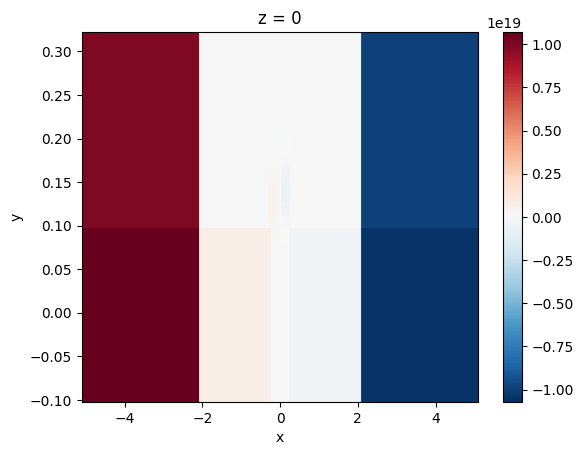

In [4]:
# get 2D doping distributions and visualize
import doping_hochberg as doping
acceptors_dist, donors_dist = doping.get_dopings_hochberg()

(acceptors_dist-donors_dist).plot(y="y")

### Create mediums

In [5]:
SiO2 = td.Medium(
    electric_spec=td.InsulatorSpec(permittivity=3.9), name="SiO2",
)

# not specifying any model should default to Si models
Si_2D_doping = td.Medium(
    electric_spec=td.SemiConductorSpec(
        permittivity=11.7,
        donors=donors_dist,
        acceptors=acceptors_dist,
    ),
    name="Si_nnn",
)

aux_left = td.Medium(
    heat_spec=td.SolidSpec(conductivity=1, capacity=1),
    name="aux_left"
)

aux_right = td.Medium(
    heat_spec=td.SolidSpec(conductivity=1, capacity=1),
    name="aux_right"
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

### Generate structures

In [6]:
# create objects
overlap_factor = 1.0001

oxide = td.Structure(
    geometry=td.Box(center=(0, h_core, 0), size=(10, 5, z_size)),
    medium=SiO2,
    name="oxide"
)

core_p = td.Structure(
    geometry=td.Box(center=(-w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_p"
)

core_n = td.Structure(
    geometry=td.Box(center=(w_core/2, h_core/2, 0), size=(w_core, h_core, z_size)),
    medium=Si_2D_doping,
    name="core_n"
)

clearance_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_p"
)

clearance_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance/2, h_clearance/2, 0), size=(w_clearance, h_clearance, z_size)),
    medium=Si_2D_doping,
    name="clearance_n"
)

side_p = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_p"
)

side_n = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side/2, h_side/2, 0), size=(w_side, h_side, z_size)),
    medium=Si_2D_doping,
    name="side_n"
)

# create a couple structs to define the contacts
contact_left = td.Structure(
    geometry=td.Box(center=(-w_core - w_clearance - w_side + w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_left,
    name="contact_left"
)

contact_right = td.Structure(
    geometry=td.Box(center=(w_core + w_clearance + w_side - w_contact/2, h_side + h_contact/2, 0), size=(w_contact, h_contact, z_size)),
    medium=aux_right,
    name="contact_right"
)

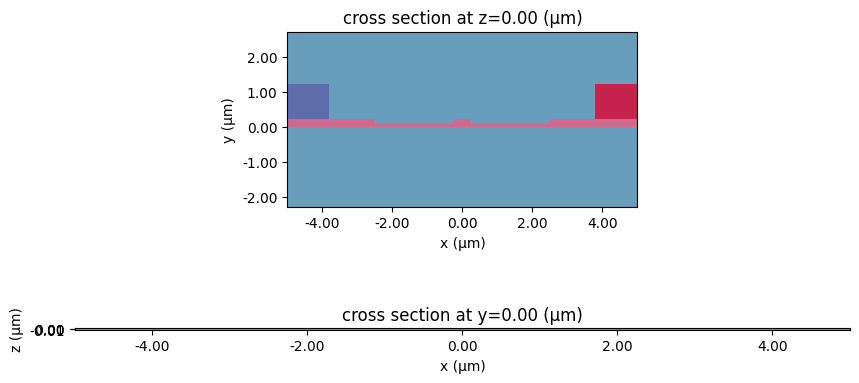

In [7]:
# create a scene with the previous structures
all_structures = [oxide, core_p, core_n, clearance_n, clearance_p, side_p, side_n, contact_left, contact_right]

scene = td.Scene(
    medium=air,
    structures=all_structures,
)


_, ax = plt.subplots(2, 1, figsize=(10, 5))

scene.plot(z=0, ax=ax[0])
scene.plot(y=5e-6, ax=ax[1])
plt.show()

### BCs

In [8]:
# create BCs
voltages = [-0.5, 0, 1, 2, 3, 4]

bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(voltage=0),
    placement=td.StructureBoundary(structure=contact_left.name),
)

bc_v2 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(voltage=voltages),
    placement=td.StructureBoundary(structure=contact_right.name),
)

boundary_conditions = [bc_v1, bc_v2]

### Monitors

In [9]:
# capacitance monitors
capacitance_global_mnt = td.CapacitanceMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, 0), name="capacitance_global_mnt",
)

# charge monitor around the waveguide
capacitance_wvg_mnt = td.CapacitanceMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="capcitance_wvg_mnt",
)

# charge monitor around the waveguide
charge_3D_mnt = td.FreeCarrierMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, td.inf), name="charge_3D_mnt", unstructured=True
)

charge_monitor_z0 = td.FreeCarrierMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="charge_z0", unstructured=True, 
)

# voltage monitor around waveguide
voltage_monitor_z0 = td.VoltageMonitor(
    center=(0, 0.14, 0), size=(0.6, 0.3, 0), name="voltage_z0", unstructured=True, 
)

# Will be used later for the mode simulations
charge_monitor_z0_big = td.FreeCarrierMonitor(
    center=(0, 0.14, 0), size=(td.inf, td.inf, 0), name="charge_z0_big", unstructured=True, conformal=True
)

### Create simulation

In [10]:
# devsim setting 
from tidy3d import ChargeToleranceSpec, DCSpec

dc_spec = DCSpec(dv=10)
convergence_settings = ChargeToleranceSpec(rel_tol=1e5, abs_tol=3e3, max_iters=400)

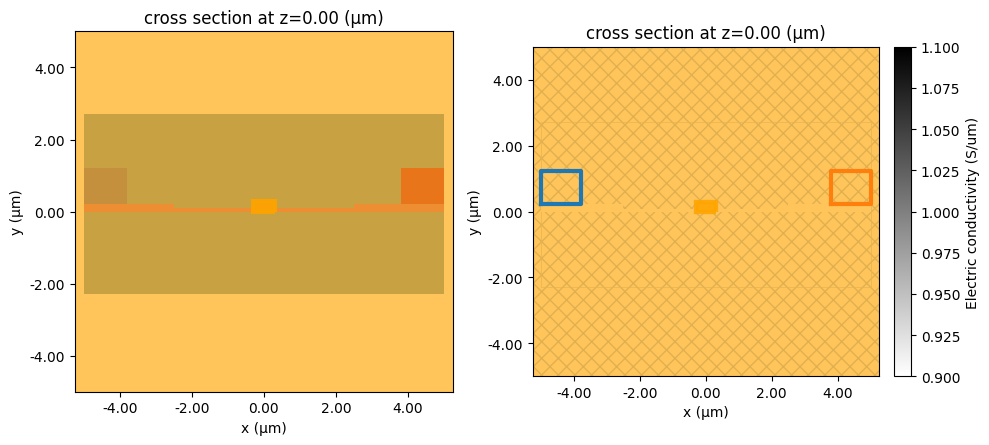

In [11]:
# mesh
mesh = td.DistanceUnstructuredGrid(dl_interface=res*1.15, dl_bulk=res*4, distance_interface=0.02*h_side,
    distance_bulk=1*h_side, relative_min_dl=0,
    uniform_grid_mediums=[Si_2D_doping.name],
    non_refined_structures=[oxide.name]
)

# build heat simulation object
charge_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[capacitance_global_mnt, capacitance_wvg_mnt, charge_3D_mnt, charge_monitor_z0, voltage_monitor_z0, charge_monitor_z0_big],
    charge_tolerance=convergence_settings,
    charge_regime=dc_spec,
    center=(0,0,0),
    size=(10.5,10,5),
    structures=all_structures,
    medium=air,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    symmetry=(0, 0, 0)
    )

# plot simulation
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
charge_sim.plot(z=0, ax=ax[0])
charge_sim.plot_property(z=0, property="electric_conductivity", ax=ax[1])
plt.tight_layout()
plt.show()

### Run pipeline

In [12]:
%matplotlib inline
from run_drift import run_drift
charge_data = run_drift(charge_sim)

# run on server
#from tidy3d import web
#charge_data=web.run(charge_sim, task_name="test_prash", solver_version="dd-devsim-0.0.0", path="charge_web.hdf5")

[24-12-17 20:34:53.019][DEBUG  ]: environ({'SHELL': '/bin/bash', 'SESSION_MANAGER': 'local/marc-legion:@/tmp/.ICE-unix/3791,unix/marc-legion:/tmp/.ICE-unix/3791', 'QT_ACCESSIBILITY': '1', 'COLORTERM': 'truecolor', 'XDG_CONFIG_DIRS': '/etc/xdg/xdg-ubuntu:/etc/xdg', 'XDG_MENU_PREFIX': 'gnome-', 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated', '__MODULES_LMALTNAME': 'cuda/12.6&as|cuda/default&as|cuda/latest:hdf5/1.14.3&as|hdf5/default&as|hdf5/latest:glpk/4.35&as|glpk/default&as|glpk/latest:lapack/current&as|lapack/default&as|lapack/latest:openBLAS/0.3.26&as|openBLAS/default&as|openBLAS/latest', 'MANDATORY_PATH': '/usr/share/gconf/ubuntu.mandatory.path', 'LC_ADDRESS': 'en_US.UTF-8', 'GNOME_SHELL_SESSION_MODE': 'ubuntu', 'LC_NAME': 'en_US.UTF-8', 'SSH_AUTH_SOCK': '/run/user/1000/keyring/ssh', 'MEMORY_PRESSURE_WRITE': 'c29tZSAyMDAwMDAgMjAwMDAwMAA=', 'AMGX_FLOW360_PATH': '/usr/local/amgx/current', 'XMODIFIERS': '@im=ibus', 'DESKTOP_SESSION': 'ubuntu', 'LC_MONETARY': 'en_US.UTF-8', 'GTK_MODUL

/home/marc/Documents/src/tidy3d-core/_build_release/tidy3d_backend/devsim_setup.py:407: RuntimeWarning: divide by zero encountered in log
  np.log(total_impurities / model.n2)
/home/marc/Documents/src/tidy3d-core/_build_release/tidy3d_backend/devsim_setup.py:408: RuntimeWarning: divide by zero encountered in log
  + np.sqrt(np.power(np.log(total_impurities / model.n2), 2) + model.c2)
/home/marc/Documents/src/tidy3d-core/_build_release/tidy3d_backend/devsim_setup.py:407: RuntimeWarning: invalid value encountered in add
  np.log(total_impurities / model.n2)


Interpolating Acceptors in region zone_6
Interpolating Donors in region zone_7
Interpolating Acceptors in region zone_7
Region: zone_1, Equation: PotentialEquation, Variable: Potential
Region: zone_2, Equation: PotentialEquation, Variable: Potential
Region: zone_3, Equation: PotentialEquation, Variable: Potential
Region: zone_4, Equation: PotentialEquation, Variable: Potential
Region: zone_5, Equation: PotentialEquation, Variable: Potential
Region: zone_6, Equation: PotentialEquation, Variable: Potential
Region: zone_7, Equation: PotentialEquation, Variable: Potential
number of equations 384501
Iteration: 0
  Device: "device"	RelError: 2.01500e+03	AbsError: 1.33991e+19
    Region: "zone_1"	RelError: 1.00000e+00	AbsError: 2.58564e-01
      Equation: "PotentialEquation"	RelError: 1.00000e+00	AbsError: 2.58564e-01
    Region: "zone_2"	RelError: 3.00000e+00	AbsError: 1.00537e+19
      Equation: "ElectronContinuityEquation"	RelError: 1.00000e+00	AbsError: 5.10328e+18
      Equation: "HoleCo

Traceback (most recent call last):
  File "/home/marc/Documents/src/tidy3d-core/_build_release/bin/denormalize.py", line 34, in <module>
    denormalize(simfile, save_dir, mode_solver_path)
  File "/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/tidy3d_denormalizer/denormalizer.py", line 207, in denormalize
    denormalize_directly(sim_data=sim_data, base_dir=base_dir)
                                  ^^^^^^^^
UnboundLocalError: cannot access local variable 'sim_data' where it is not associated with a value
Traceback (most recent call last):
  File "/home/marc/Documents/src/tidy3d-core/_build_release/bin/flow360runner.py", line 36, in <module>
    subprocess.check_call([sys.executable, '-u'] + args)
  File "/usr/lib/python3.12/subprocess.py", line 413, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/home/marc/Documents/tidy3D_python/tidy3d_local/bin/python3', '-u', '/home/marc/Documents/src/tidy3d-core/_b

[24-12-17 20:42:21.803][SUPPORT]: **********   End content of postVizDenormalize.log **********
[24-12-17 20:42:21.803][SUPPORT]: Finishing postVizDenormalize: execution time is 1.65 seconds
[24-12-17 20:42:21.803][DEBUG  ]: runCommand for postVizDenormalize failed
[24-12-17 20:42:21.803][SUPPORT]: runCommand for postVizDenormalize failed
[24-12-17 20:42:21.803][SUPPORT]: Running UpdateClient2 : /bin/true denormalizeStatus : error
[24-12-17 20:42:21.808][SUPPORT]: **********   Begin content of UpdateClient2.log **********
[24-12-17 20:42:21.809][SUPPORT]: **********   End content of UpdateClient2.log **********
[24-12-17 20:42:21.809][SUPPORT]: Finishing UpdateClient2: execution time is 0.01 seconds
[24-12-17 20:42:21.809][SUPPORT]: Compressing ./output/simulation_data.hdf5.
[24-12-17 20:42:21.809][SUPPORT]: Pigz binary is not found. Using gzip.
[24-12-17 20:42:35.780][SUPPORT]: Running uploadFiles : /bin/true 
[24-12-17 20:42:35.781][SUPPORT]: **********   Begin content of uploadFiles

20:42:36 CET WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

             WARNING: Could not execute validator 'warn_no_data' because field  
             'monitor' failed validation.                                       

### Post-process Charge simmulation

(-0.5, 0.0, 1.0, 2.0, 3.0, 4.0)


/home/marc/Documents/tidy3D_python/tidy3d_local/lib/python3.12/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


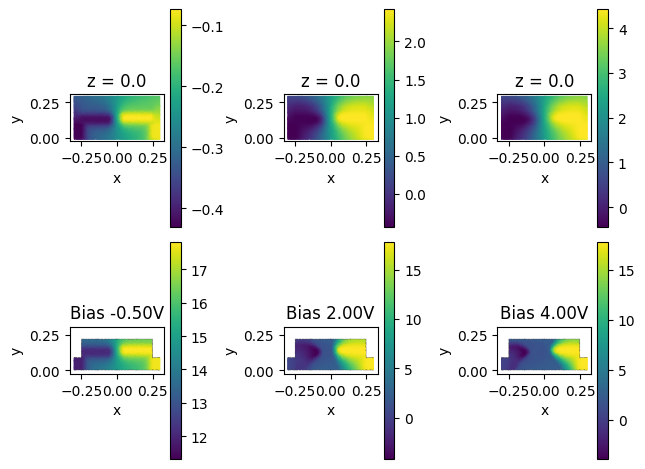

In [13]:
#charge_data[volt_y0_mnt.name].voltage.sel(z=0).plot(grid=False)
print(charge_data[charge_3D_mnt.name].holes_series.parameter_array)

indices = [0]
indices.append(int(np.ceil(charge_data[charge_3D_mnt.name].holes_series.num_fields_saved/2)))
indices.append(int(np.ceil(charge_data[charge_3D_mnt.name].holes_series.num_fields_saved-1)))

series_electrons = charge_data[charge_3D_mnt.name].electrons_series
#series_holes = charge_data[charge_3D_mnt.name].holes_series
series_potential = charge_data[voltage_monitor_z0.name].voltage_series

sets_to_plot = [[], []]
fig, ax = plt.subplots(2, 3)

for n, index in enumerate(indices):
    # let's read voltage first
    sets_to_plot[0].append(
        series_potential.get_field(index)
    )
    sets_to_plot[0][n].plot(ax=ax[0][n], grid=False)

    # now let's plot some electrons
    sets_to_plot[1].append(
        np.log10(series_electrons.get_field(index).sel(z=0))
    )
    sets_to_plot[1][n].plot(ax=ax[1][n], grid=False)
    ax[1][n].set_title("Bias {0:0.2f}V".format(series_electrons.parameter_array[index]))

plt.tight_layout()

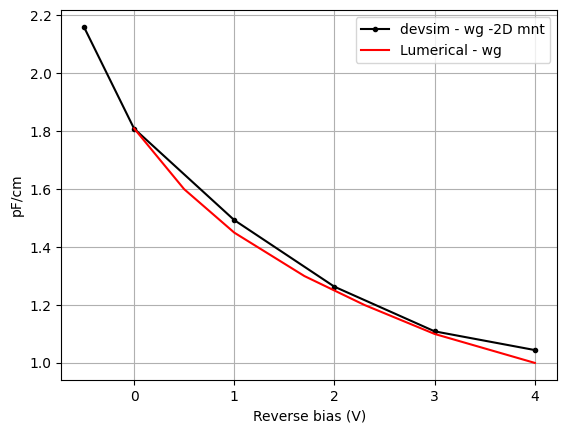

In [14]:
# capacitance from monitor - waveguide area
c_lumerical_wg_in_SiO2 = np.array([0.181, 0.16, 0.145, 0.13, 0.12, 0.11, 0.1])
b_lumerical_wg_in_SiO2 = np.array([0,     0.5,   1,    1.7,  2.3,  3,     4])


mnt_v = np.array(charge_data[capacitance_wvg_mnt.name].hole_capacitance.coords["Voltage (V)"].data)
mnt_ce = np.array(charge_data[capacitance_wvg_mnt.name].electron_capacitance.data)
mnt_ch = np.array(charge_data[capacitance_wvg_mnt.name].hole_capacitance.data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10, 'k.-', label="devsim - wg -2D mnt")
plt.plot(b_lumerical_wg_in_SiO2, c_lumerical_wg_in_SiO2*10, 'r-', label="Lumerical - wg")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()
#charge_data[charge_monitor_z0.name].capacitance_curve["cv_curve_e"].plot()

### Comparison against experimental data

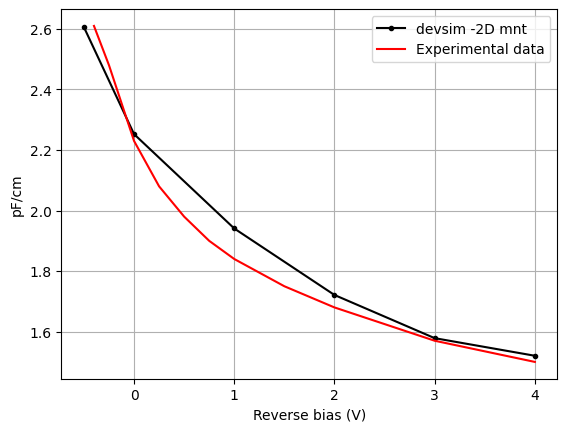

In [15]:
# capacitance from monitor - waveguide area
CV_baehrjones = [
    [-0.4, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4],
    [0.261, 0.248, 0.223, 0.208, 0.198, 0.190, 0.184, 0.175, 0.168, 0.157, 0.150]]


mnt_v = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.coords["Voltage (V)"].data)
mnt_ce = np.array(charge_data[capacitance_global_mnt.name].electron_capacitance.data)
mnt_ch = np.array(charge_data[capacitance_global_mnt.name].hole_capacitance.data)

plt.plot(mnt_v, -0.5*(mnt_ce+mnt_ch) * 10 , 'k.-', label="devsim -2D mnt")
plt.plot(CV_baehrjones[0], np.array(CV_baehrjones[1])*10, 'r-', label="Experimental data")

plt.xlabel("Reverse bias (V)")
plt.ylabel("pF/cm")
plt.legend()
plt.grid()

## Generate Charge-dependent perturbation material

In [16]:
# define first the range of frequencies of interest

wvl_um = 1.55
freq0 = td.C_0 / wvl_um

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

# max/min wavelengths
print(np.max(wvls), np.min(wvls))

1.5816326530612244 1.519607843137255


In [17]:
si = td.material_library['cSi']['Palik_Lossless']
SiO2_lib = td.material_library['SiO2']['Palik_Lossy']

n_si, k_si = si.nk_model(frequency=td.C_0 / wvl_um)

In [18]:
# Import material data from Lumerical (see notebook "Lumerical_material_fitting.ipynt")
#Si_lumerical = td.PoleResidue.from_file("fitted_si.json")
#SiO2_lumerical = td.PoleResidue.from_file("fitted_sio2.json")

# using fitted Lumerical material properties
#n_si, k_si = Si_lumerical.nk_model(frequency=td.C_0 / wvl_um)

#print(si.eps_comp(row=0, col=0, frequency=td.C_0 / 1.55))
#print(Si_lumerical.eps_comp(row=0, col=0, frequency=td.C_0 / 1.55))

In [19]:
ne_coeff = -5.4e-22 * 1.1
ne_pow = 1.011

nh_coeff = -1.53e-18 * 1.1
nh_pow = 0.838

k_factor = wvl_um * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21 * 1.1
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20 * 1.1
kh_pow = 1.109

In [20]:
Ne_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))
Nh_range = np.concatenate(([0], np.logspace(-6, 20, num=200)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

dn_mesh = ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
dk_mesh = ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

In [21]:
si_non_perturb = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)

In [22]:
dn_data = td.ChargeDataArray(dn_mesh, coords=dict(n=Ne_range, p=Nh_range))
dk_data = td.ChargeDataArray(dk_mesh, coords=dict(n=Ne_range, p=Nh_range))

n_si_charge = td.CustomChargePerturbation(perturbation_values=dn_data)
k_si_charge = td.CustomChargePerturbation(perturbation_values=dk_data)

n_si_perturbation = td.ParameterPerturbation(
    charge=n_si_charge,
)

k_si_perturbation = td.ParameterPerturbation(
    charge=k_si_charge,
)

si_perturb = td.PerturbationMedium.from_unperturbed(
    medium=si_non_perturb,
    perturbation_spec=td.IndexPerturbation(
        delta_n=n_si_perturbation,
        delta_k=k_si_perturbation,
        freq=freq0,
    )
)

## Create mode simulation

### Regenerate structures with larger span and perturbed material

In [23]:
span = 2*wvl_um

In [24]:
new_structs = []
for struct in charge_sim.structures:
    # NOTE: take only structures for which we have doping
    if isinstance(struct.medium.electric_spec, td.SemiConductorSpec):
        #new_size = list(struct.geometry.size)
        #new_size[2] = span
        #new_geometry = struct.geometry.updated_copy(size=new_size)
        #new_structs.append(struct.updated_copy(geometry=new_geometry, medium=si_perturb))
        new_structs.append(struct.updated_copy(medium=si_perturb))

# let's first try without removing oxide
scene = td.Scene(
    medium=air,
    structures=new_structs,
)

### Define mode source

In [25]:
buffer = 1*wvl_um

port_center = (0,h_core,-span/2)
port_size = (5, 5, 0)

### Create simulation

In [26]:
sim_size = (13+buffer, 10+buffer, span)
bc_spec = td.BoundarySpec(
    x = td.Boundary.pml(num_layers=20),
    y = td.Boundary.pml(num_layers=30),
    z = td.Boundary.periodic(),
)

sim = td.Simulation(
    center=(0,0,0),
    size=sim_size,
    medium=td.Medium(permittivity=3.9),
    structures=scene.structures,
    run_time=6e-12,
    boundary_spec=bc_spec,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=wvl_um)
)

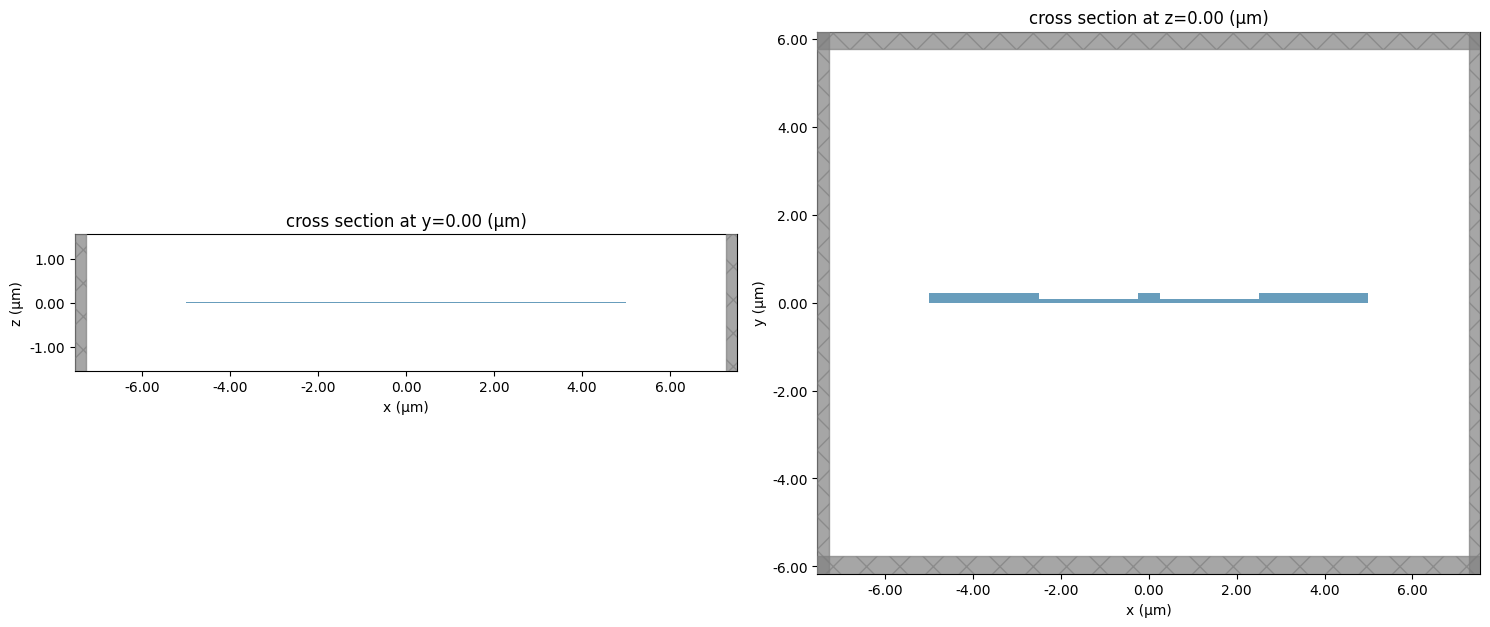

In [27]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
sim.plot(y=sim.center[1], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

In [28]:
def apply_charge(charge_data):
    perturbed_sims = []
    for n, v in enumerate(charge_data[charge_monitor_z0_big.name].electrons_series.parameter_array):
        e_data = charge_data[charge_monitor_z0_big.name].electrons_series.get_field(n)
        h_data = charge_data[charge_monitor_z0_big.name].holes_series.get_field(n)
        perturbed_sims.append(
            sim.perturbed_mediums_copy(
                electron_density=e_data, 
                hole_density=h_data,
            )
        )
    return perturbed_sims

perturbed_sims = apply_charge(charge_data)

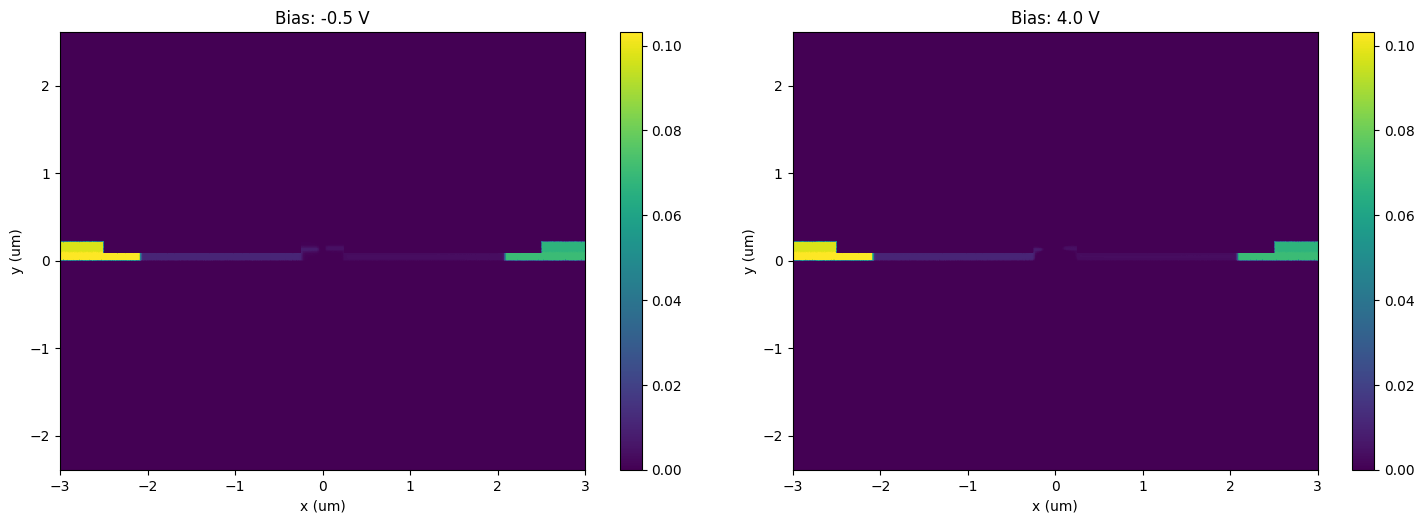

In [29]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

sampling_region = td.Box(center=(0, h_core/2, 0), size=(6, 5, 1))
#eps_undoped = sim.epsilon(box=sampling_region).isel(z=0, drop=True)
eps_undoped = sim.epsilon(box=sampling_region).sel(z=0, method="nearest")

for ax_ind, ind in enumerate([0, len(voltages)-1]):
    #eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).isel(z=0,  drop=True)
    eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).sel(z=0, method="nearest")
    eps_doped = eps_doped.interp(x=eps_undoped.x, y=eps_undoped.y)
    eps_diff = np.abs(np.real(eps_doped - eps_undoped))
    eps_diff.plot(x="x", ax=ax[ax_ind])
    
    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {voltages[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("x (um)")
    ax[ax_ind].set_ylabel("y (um)")

plt.tight_layout()
plt.show()

### Waveguide mode analysis

In [30]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run_batch as run_mode_batch

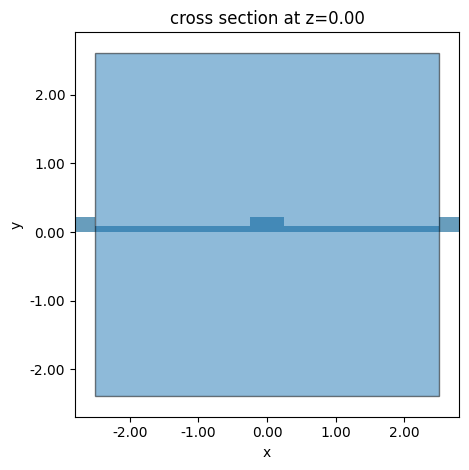

In [31]:
mode_plane = td.Box(center=(0, h_core / 2, 0), size=port_size)

# visualize
ax = sim.plot(z = 0)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

In [32]:
mode_solvers = []
for psim in perturbed_sims:
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )
    mode_solvers.append(ms)

In [33]:
# server mode computation
ms_data = run_mode_batch(mode_solvers=mode_solvers)

20:42:45 CET Running a batch of 6 mode solvers.                                 
             

Output()

20:42:51 CET WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

20:42:52 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[2]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[3]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[4]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[5]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

20:42:53 CET WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 11 WARNING messages.                           

20:47:48 CET A batch of `ModeSolver` tasks completed successfully!

### local run
import sys
sys.path.append("/home/marc/Documents/src/tidy3d-core")
from tidy3d_backend.mode import BackendModeSolver
ms_data = []
for psim in perturbed_sims:
    ms = BackendModeSolver(
        eig_solver="auto",
        thread_size=20,
        thread_size_excluded_parallel_solver=20,
        simulation=psim,
        plane=mode_plane,
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
        freqs=freqs,
        subpixel_scheme=0,
        #colocate=colocate,
        #direction=direction,
    )
    ms_data.append(ms.solve())

In [34]:
ms_data[0].to_dataframe()

,,wavelength,n eff,k eff,loss (dB/cm),TE (Ex) fraction,wg TE fraction,wg TM fraction,mode area
f,mode_index,,,,,,,,
1.895462e+14,0,1.581633,2.668156,0.000014,4.937240,0.991320,0.904927,0.833765,0.241834
1.903199e+14,0,1.575203,2.671876,0.000014,4.936663,0.991373,0.905109,0.834050,0.239660
1.910935e+14,0,1.568826,2.675576,0.000014,4.936028,0.991426,0.905296,0.834337,0.237526
1.918672e+14,0,1.562500,2.679256,0.000014,4.935343,0.991479,0.905488,0.834627,0.235431
1.926408e+14,0,1.556225,2.682916,0.000014,4.934615,0.991532,0.905684,0.834919,0.233374
1.934145e+14,0,1.550000,2.686557,0.000014,4.933850,0.991584,0.905885,0.835213,0.231354
1.941881e+14,0,1.543825,2.690178,0.000014,4.933051,0.991637,0.906090,0.835509,0.229371
1.949618e+14,0,1.537698,2.693779,0.000014,4.932221,0.991690,0.906300,0.835807,0.227424
1.957355e+14,0,1.531621,2.697361,0.000014,4.931359,0.991743,0.906513,0.836108,0.225511


### Visualize 1st mode

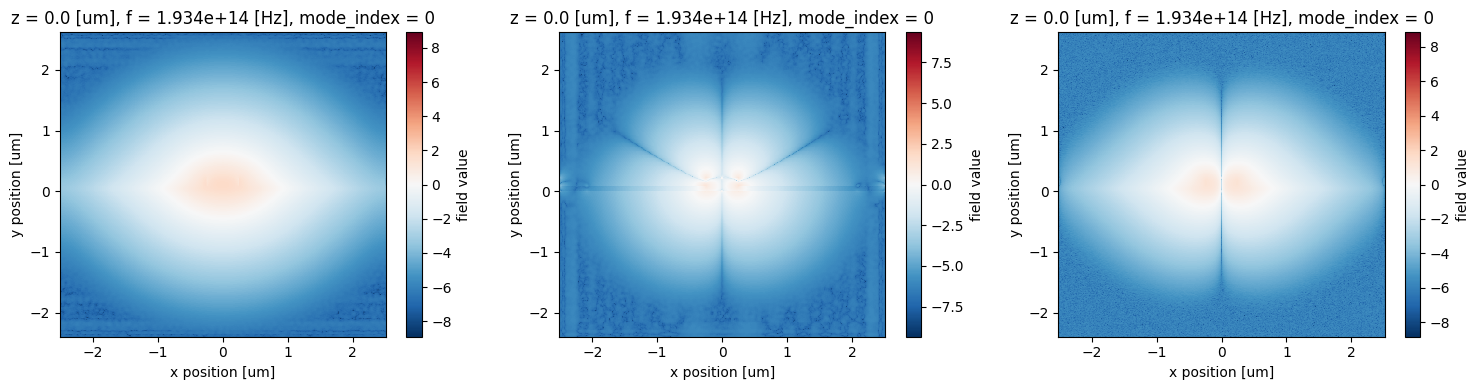

In [35]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
np.log10(np.abs(ms_data[0].Ex.sel(z=0, f=freq0))).plot(ax=ax[0], x="x")
np.log10(np.abs(ms_data[0].Ey.sel(z=0, f=freq0))).plot(ax=ax[1], x="x")
np.log10(np.abs(ms_data[0].Ez.sel(z=0, f=freq0))).plot(ax=ax[2], x="x")
plt.tight_layout()

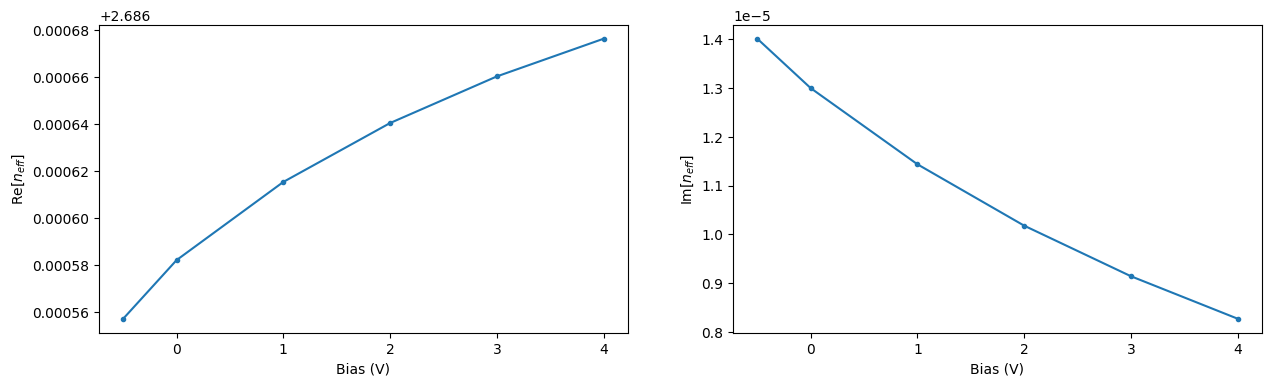

In [36]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for md in ms_data]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, np.real(n_eff_freq0), ".-")

ax[0].set_xlabel("Bias (V)")
ax[0].set_ylabel("Re[$n_{eff}$]")

ax[1].plot(voltages, np.imag(n_eff_freq0), ".-")

ax[1].set_xlabel("Bias (V)")
ax[1].set_ylabel("Im[$n_{eff}$]")

plt.show()

### Relative phase change

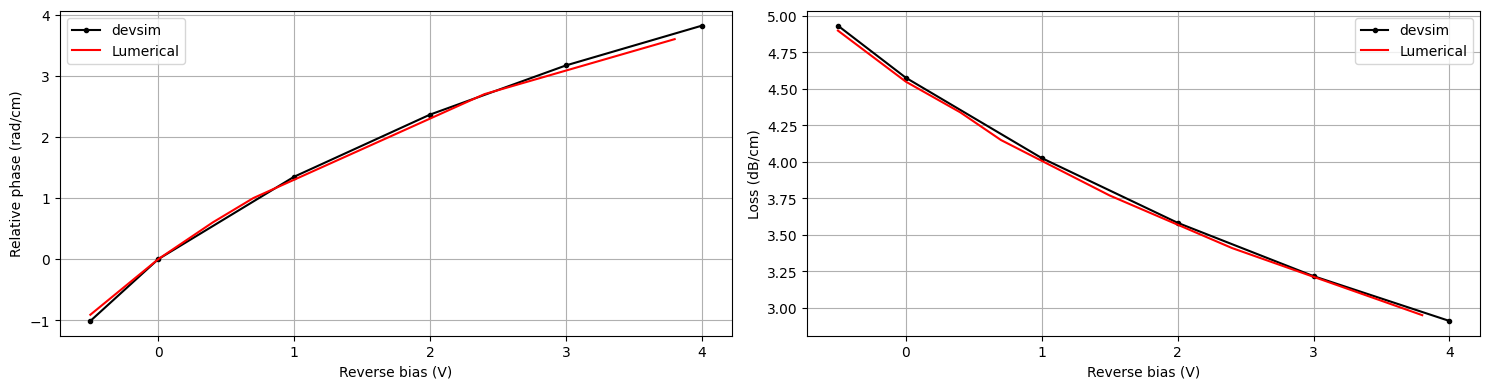

In [37]:
ind_V0 = 1
delta_neff = np.real(n_eff_freq0 - n_eff_freq0[ind_V0])
rel_phase_change = 2*np.pi*delta_neff/wvl_um * 1e4
alpha_dB_cm = 10*4*np.pi*np.imag(n_eff_freq0)/wvl_um*1e4*np.log10(np.exp(1))

# lumerical results
v_lumerical = [-0.5, 0, 0.4, 0.7, 1.5, 2.4, 3.8]
pc_lumerical=[-0.91, 0, 0.6, 1,   1.8, 2.7, 3.6]
loss_lumerical = [4.9, 4.55, 4.34, 4.15, 3.77, 3.41, 2.95]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, rel_phase_change, 'k.-', label="devsim")
ax[0].plot(v_lumerical, pc_lumerical, 'r-', label="Lumerical")
ax[0].set_xlabel("Reverse bias (V)")
ax[0].set_ylabel("Relative phase (rad/cm)")
ax[0].grid()
ax[0].legend()

ax[1].plot(voltages, alpha_dB_cm, 'k.-', label="devsim")
ax[1].plot(v_lumerical, loss_lumerical, 'r-', label="Lumerical")
ax[1].set_xlabel("Reverse bias (V)")
ax[1].set_ylabel("Loss (dB/cm)")
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()